In [4]:
from beattrack.model import BeatNet
import torchaudio
from torchaudio.transforms import MelSpectrogram
from pathlib import Path
from IPython.display import Audio
import librosa
from einops import rearrange
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from madmom.features import DBNBeatTrackingProcessor

In [5]:
n_fft = 2048
win_length = None
sample_rate = 44100
hop_size = round(sample_rate / 100)  # 10ms hop size
n_mels = 81
window = torch.hann_window(n_fft)
data_length = 30 * sample_rate  # 30 seconds of audio
mel_spec = MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    hop_length=hop_size,
    win_length=win_length,
    n_mels=n_mels,
)
def preprocess(audio_path):
    audio, sr = torchaudio.load(audio_path)
    data_length = 30 * sample_rate  # 30 seconds of audio
    # Pad or trim to 30 seconds
    if audio.shape[1] < data_length:
        audio = F.pad(audio, (0, data_length - audio.shape[1]))
    else:
        audio = audio[:, :data_length]
    mel = mel_spec(audio)
    channels, bins, frames = mel.shape
    print(mel.shape)
    mel = rearrange(mel, "c b f -> f (b c)")
    print(mel.shape)
    return mel


In [65]:
model = BeatNet.load_from_checkpoint("ckpts/last.ckpt")
model = model.eval()

dbn = DBNBeatTrackingProcessor(min_bpm=55, max_bpm=215, transition_labmda = 100, fps=100)

In [47]:
files = []
root = Path("data/ballroom")
for folder in root.iterdir():
    if folder.is_dir():
        for file in folder.iterdir():
            if file.suffix == ".wav":
                files.append(file)
                break

In [85]:
test = files[2]
mel = preprocess(test)

torch.Size([1, 81, 3001])
torch.Size([3001, 81])


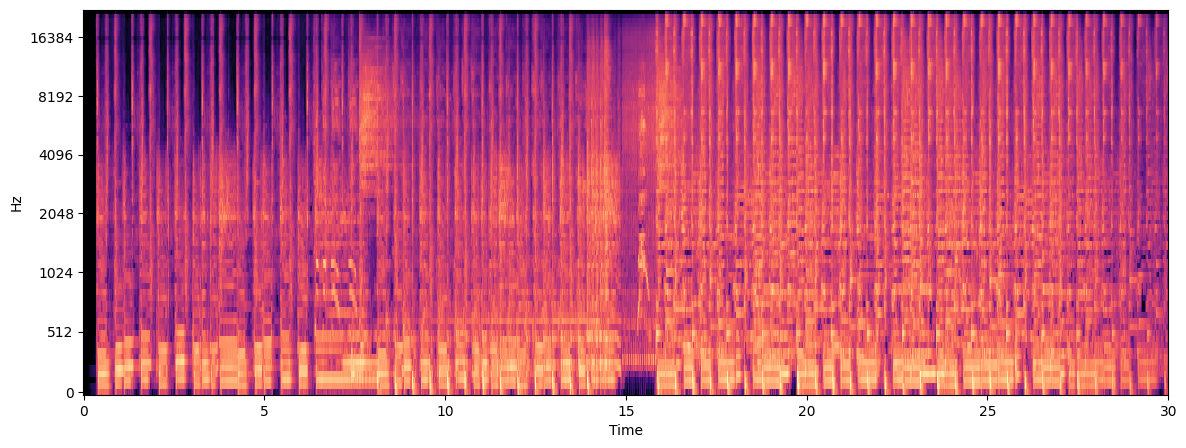

In [86]:
audio, sr = librosa.load(test, sr=sample_rate)
plt.figure(figsize=(14, 5))
S_dB = librosa.power_to_db(mel.T.numpy(), ref=np.max)
librosa.display.specshow(S_dB, sr=sr, x_axis="time", y_axis="mel", n_fft = n_fft, hop_length=hop_size)
Audio(audio, rate=sr)


In [87]:
mel = mel.unsqueeze(0).unsqueeze(0)
mel.shape

torch.Size([1, 1, 3001, 81])

In [88]:
with torch.no_grad():
    beats = model(mel)
beat_times = dbn(beats.squeeze(0).squeeze(0))

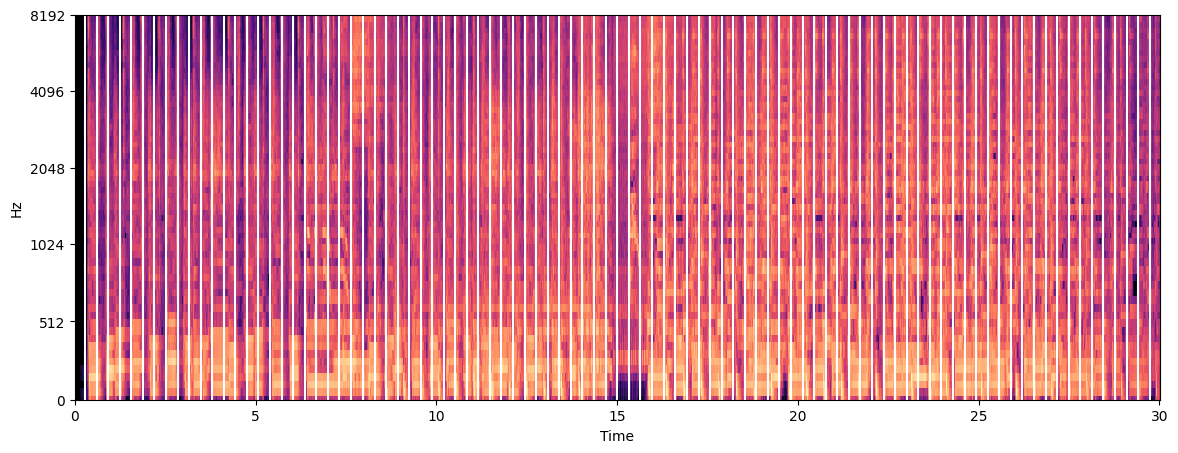

In [94]:
play_clicks = True
plt.figure(figsize=(14, 5))
librosa.display.specshow(S_dB, sr=sr, x_axis="time", y_axis="mel", n_fft = n_fft, hop_length=hop_size)
plt.vlines(beat_times, 0, 8192, color='w')
plt.ylim(0, 8192)

clicks = librosa.clicks(times = outputs, sr=sr, length=len(audio))
output = audio
if play_clicks:
    output = audio + clicks
Audio(output, rate=sr)

In [90]:
len(beat_times), beat_times[:5]

(93, array([0.28, 0.6 , 0.92, 1.25, 1.56]))

In [91]:
def label2vec(label_file: Path, hop_size: int, num_frames: int) -> torch.Tensor:
    labels = [0] * num_frames
    for line in label_file.open("r"):
        time, beat_num = line.split(" ")
        frame_id = round(float(time) * sample_rate / hop_size)
        if frame_id < num_frames:
            labels[frame_id] = 1
    return torch.tensor(labels)
label_root = root / "beats"
label_file = label_root / f"{test.stem}.beats"
label = label2vec(label_file, hop_size, mel.shape[2])
# loss = F.binary_cross_entropy(beats.squeeze(1), label.view(1, -1).float())
# print(loss)

In [92]:
outputs = []
for i, lab in enumerate(label):
    if lab == 1:
        outputs.append(i * hop_size / sample_rate)

In [93]:
outputs

[0.36,
 0.85,
 1.34,
 1.82,
 2.31,
 2.8,
 3.28,
 3.76,
 4.24,
 4.72,
 5.2,
 5.68,
 6.17,
 6.65,
 7.14,
 7.62,
 8.11,
 8.6,
 9.08,
 9.57,
 10.05,
 10.53,
 11.02,
 11.5,
 11.99,
 12.47,
 12.95,
 13.44,
 13.92,
 14.41,
 14.89,
 15.37,
 15.86,
 16.34,
 16.82,
 17.3,
 17.79,
 18.27,
 18.76,
 19.24,
 19.73,
 20.21,
 20.69,
 21.17,
 21.65,
 22.13,
 22.62,
 23.1,
 23.59,
 24.07,
 24.56,
 25.04,
 25.53,
 26.01,
 26.5,
 26.98,
 27.47,
 27.95,
 28.44,
 28.92,
 29.41,
 29.89]